<a href="https://colab.research.google.com/github/yupopov/stepik_ml_contest/blob/master/main_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Тренировка модели

In [ ]:
# Для запуска на github
!git clone https://github.com/yupopov/stepik_ml_contest
import os
os.chdir('stepik_ml_contest')

Cloning into 'stepik_ml_contest'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 37 (delta 9), reused 36 (delta 8), pack-reused 0
Unpacking objects: 100% (37/37), done.


In [ ]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.base import clone
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

from config.config import TOTAL_DAYS, PATH_TO_DATA
# рассматриваем данные за первые TOTAL_DAYS дней активности
from utils.df_creation import get_users, create_interaction, get_target, get_min_timestamps,\
    cut_df_by_time, cut_dfs_by_time, get_action_counts_by_period, get_base_features

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
RANDOM_STATE = 42

In [ ]:
def test_model(model, X, y, test_size=0.1, cv=5, random_state=RANDOM_STATE):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

  model_ = clone(model)
  model_.random_state = random_state
  model_.fit(X_train, y_train)

  roc_train = roc_auc_score(y_train, model_.predict_proba(X_train)[:, 1])
  roc_test = roc_auc_score(y_test, model_.predict_proba(X_test)[:, 1])

  print(f'ROC-AUC на тренировочной выборке:\t {roc_train}')
  print(f'ROC-AUC на тестовой выборке:\t {roc_test}\n')

  cv_results = cross_validate(model_, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, return_estimator=True)

  cv_scores = cv_results['test_score']
  cv_mean = cv_scores.mean()
  cv_std = cv_scores.std()

  print(f'Mean CV score: {cv_mean}')
  print(f'Std of CV scores: {cv_std}')

  if hasattr(model, 'feature_importances_'):
    estimators = cv_results['estimator']
    feature_importances = feature_importances = pd.DataFrame(
        np.vstack([estimator.feature_importances_ for estimator in estimators]),
        columns=X_train.columns
        ).T

    sorted_idx = feature_importances.mean(axis=1).sort_values().index
    feature_importances = feature_importances.loc[sorted_idx, :]

    fig, ax = plt.subplots()
    ax.boxplot(feature_importances,
            vert=False, labels=feature_importances.index)
    ax.set_title("Feature importances on CV")
    fig.tight_layout()


In [ ]:
def plot_learning_curve(estimator, title, X, y, scoring=None, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or a scorer callable
        object / function with signature scorer(estimator, X, y).

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, scoring=scoring, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

## Проверка базового датасета

Получим бейзлайн решение на базовых признаках, полученных в прошлой тетрадке.

Будем использовать древесные модели, потому что как мы видели в прошлой тетрадке, признаки сильно между собой коррелируют, так что использовать линейную модель было бы совсем плохо.

Как метрику качества будем использовать ROC-AUC, потому что она и указана на степике, ну и датасет не сильно несбалансированный.

In [ ]:
train_df_base = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_base.csv'), index_col='user_id')
targets = pd.read_csv(os.path.join(PATH_TO_DATA, 'targets.csv'), index_col='user_id')
test_df_base = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_data_base.csv'), index_col='user_id')

In [ ]:
train_df_base.head()

,discovered,passed,started_attempt,viewed,correct,wrong,num_days
user_id,,,,,,,
1,1,0,0,1,0,0,1
2,9,9,2,9,2,0,1
3,15,15,4,20,4,4,1
5,1,1,0,1,0,0,1
7,1,1,0,1,0,0,1


In [ ]:
X_train_base, X_test_base, y_train, y_test =\
 train_test_split(train_df_base, targets, test_size=0.1, stratify=targets)

In [ ]:
rf = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=10,
    min_samples_split=10,
    class_weight='balanced',
    n_jobs=-1
)

rf.fit(X_train_base, y_train)
roc_train = roc_auc_score(y_train, rf.predict_proba(X_train_base)[:, 1])
roc_test = roc_auc_score(y_test, rf.predict_proba(X_test_base)[:, 1])

print(f'ROC-AUC на тренировочной выборке: {roc_train}')
print(f'ROC-AUC на тестовой выборке: {roc_test}')

print('Feature importances of the model:')
print(pd.Series(rf.feature_importances_, index=X_train_base.columns).sort_values(ascending=False))


ROC-AUC на тренировочной выборке: 0.8960858906038287
ROC-AUC на тестовой выборке: 0.8177953024375477
Feature importances of the model:
passed             0.267386
correct            0.224604
discovered         0.150033
viewed             0.149821
started_attempt    0.125136
wrong              0.059659
num_days           0.023361
dtype: float64


In [ ]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

ROC-AUC на тренировочной выборке:	 0.8927060363656266
ROC-AUC на тестовой выборке:	 0.8538573683421562

Mean CV score: 0.8319259928686306
Std of CV scores: 0.01451775735022143


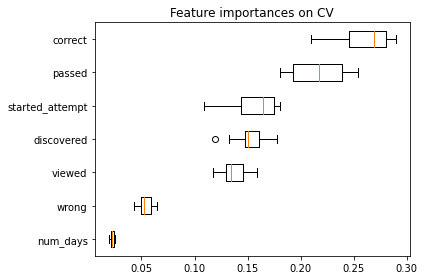

In [ ]:
test_model(rf, train_df_base, targets, random_state=None, cv=10)

In [ ]:
train_df_base.columns

Index(['discovered', 'passed', 'started_attempt', 'viewed', 'correct', 'wrong',
       'num_days'],
      dtype='object')

ROC-AUC на тренировочной выборке:	 0.8541005295241445
ROC-AUC на тестовой выборке:	 0.8125178194045599

Mean CV score: 0.8266580891789104
Std of CV scores: 0.025365319760703487


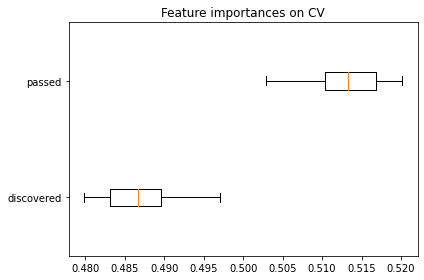

In [ ]:
test_model(rf, train_df_base[['passed', 'discovered']], targets, cv=20)

ROC-AUC на тренировочной выборке:	 0.8594604584803344
ROC-AUC на тестовой выборке:	 0.8238134848435861

Mean CV score: 0.8382105062704136
Std of CV scores: 0.01653118398316747


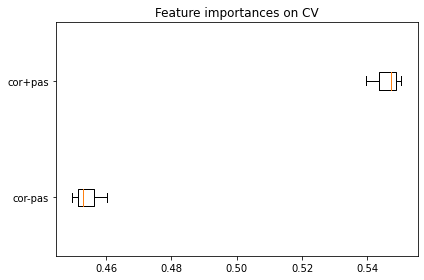

In [ ]:
cor_pas = pd.DataFrame()
cor_pas['cor+pas'] = train_df_base.correct + train_df_base.passed
cor_pas['cor-pas'] = train_df_base.correct - train_df_base.passed
test_model(rf, cor_pas, targets, cv=10)

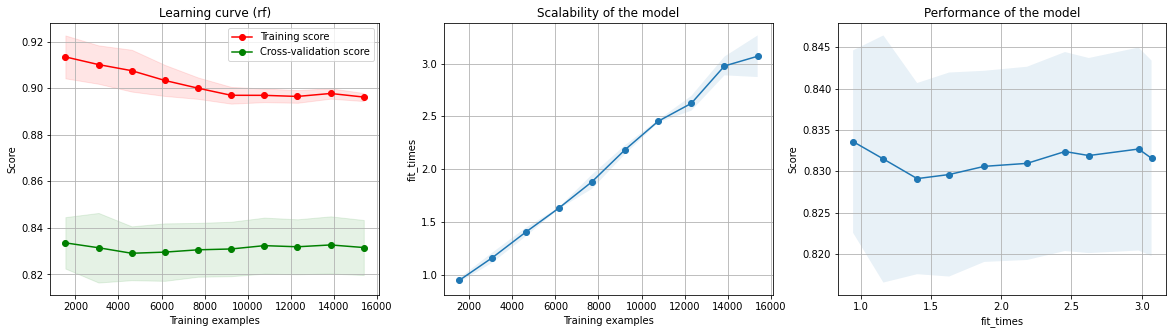

In [ ]:
plot_learning_curve(rf, 'Learning curve (rf)', train_df_base, targets, scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

Вот тут очень хорошо видно переобучение.

Можно увидеть, что метрика качества модели сильно отличается на тренировочной и тестовой выборках, а также сильно зависит от изначального разбиения. Скорее всего, датасет сильно разнородный, поэтому получаются такие разные результаты. Помимо этого, базовые признаки сильно коррелируют между собой, что тоже должно сказываться на устойчивости модели:

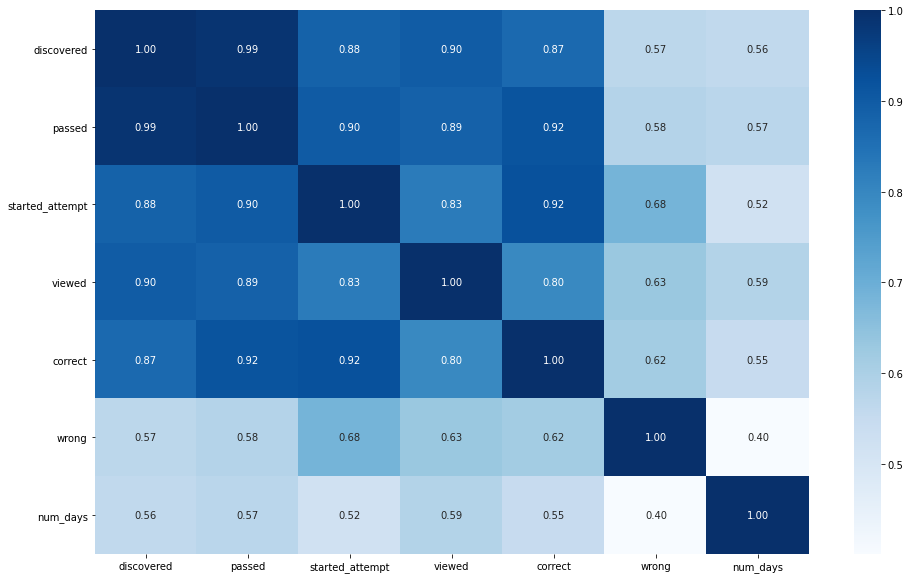

In [ ]:
plt.figure(figsize = (16, 10)) 
sns.heatmap(train_df_base.corr('pearson'), annot=True, fmt='.2f', cmap='Blues');

Так что гиперпараметры лучше подбирать на кросс-валидации, сильнее регуляризовать модель и сделать какой-нибудь отбор признаков. 

## Исправленные данные

In [ ]:
train_df_fixed = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_fixed.csv'), index_col='user_id').iloc[:, :-1]

In [ ]:
test_model(rf, train_df_fixed, targets)

ROC-AUC на тренировочной выборке:	 0.8950593880484992
ROC-AUC на тестовой выборке:	 0.8255990994036195

Feature importances of the model:
correct            0.248533
passed             0.205811
discovered         0.160892
started_attempt    0.154090
viewed             0.152554
wrong              0.056051
num_days           0.022069
dtype: float64


Mean CV score: 0.8314164722749735
Std of CV scores: 0.011955331196729948


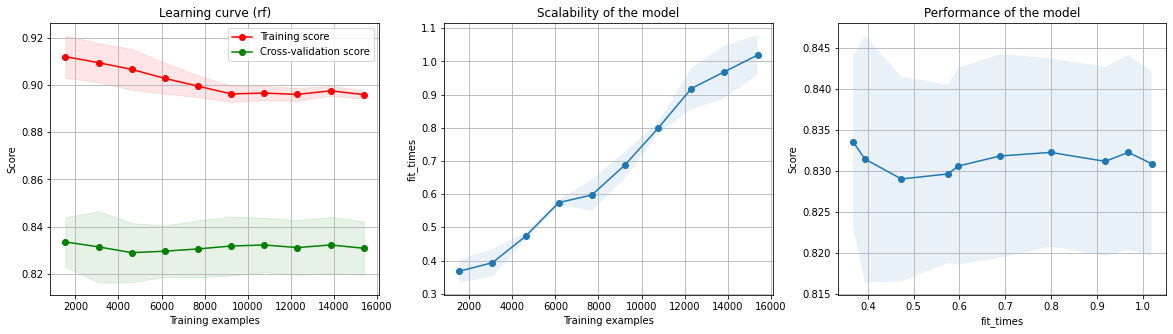

In [ ]:
plot_learning_curve(rf, 'Learning curve (rf)', train_df_fixed, targets, scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

## Неправильно подготовленные данные

Попробуем также обучить модель на неправильно подготовленных данных (см. прошлую тетрадку)

In [ ]:
train_df_wrong = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_data_wrong.csv'), index_col='user_id')

In [ ]:
test_model(rf, train_df_wrong, targets)

ROC-AUC на тренировочной выборке:	 0.9357149340191023
ROC-AUC на тестовой выборке:	 0.8794188449204776

Feature importances of the model:
correct            0.358772
passed             0.163924
started_attempt    0.121322
discovered         0.109931
wrong              0.107266
viewed             0.082481
num_days           0.056304
dtype: float64


Mean CV score: 0.8855648894273331
Std of CV scores: 0.005418325979621504


In [ ]:
test_model(rf, train_df_wrong[['correct', 'discovered', 'passed', 'viewed', 'wrong', 'started_attempt']], targets)

ROC-AUC на тренировочной выборке:	 0.933435549912629
ROC-AUC на тестовой выборке:	 0.8674559621890606

Feature importances of the model:
correct            0.419533
passed             0.173663
wrong              0.128900
started_attempt    0.118259
discovered         0.092120
viewed             0.067525
dtype: float64


Mean CV score: 0.8819040079348245
Std of CV scores: 0.006052523500850674


In [ ]:
rf.random_state = 42

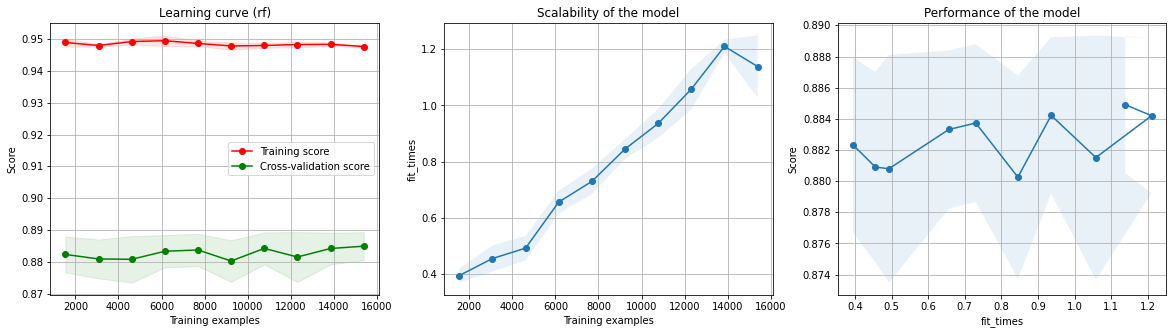

In [ ]:
plot_learning_curve(rf, 'Learning curve (rf)', train_df_wrong, targets, scoring='roc_auc', train_sizes=np.linspace(0.1, 1, 10), n_jobs=-1)

У модели, обученной на неправильно построенных признаках, метрики выше. Но это и понятно, та модель прямо берет данные из будущего.


Отбор юзеров?

In [ ]:
handpicked_outlier_users = np.loadtxt(os.path.join(PATH_TO_DATA, 'handpicked_outlier_users.txt'), dtype=int)
forest_outlier_users = np.loadtxt(os.path.join(PATH_TO_DATA, 'forest_outlier_users.txt'), dtype=int)

In [ ]:
def exclude_entries(df, index_subset):
  return df[~df.index.isin(index_subset)]

In [ ]:
rf = RandomForestClassifier(
    n_estimators=300,
    min_samples_leaf=10,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)

test_model(rf, exclude_entries(train_df_base, handpicked_outlier_users), exclude_entries(targets, handpicked_outlier_users))

ROC-AUC на тренировочной выборке:	 0.8960314527877005
ROC-AUC на тестовой выборке:	 0.826634131913635

Feature importances of the model:
correct            0.259602
passed             0.222285
discovered         0.170039
started_attempt    0.153320
viewed             0.119093
wrong              0.055501
num_days           0.020161
dtype: float64


Mean CV score: 0.8319723356027227
Std of CV scores: 0.01254023055403532


In [ ]:
test_model(rf, exclude_entries(train_df_base, forest_outlier_users), exclude_entries(targets, forest_outlier_users))

ROC-AUC на тренировочной выборке:	 0.8563806674657675
ROC-AUC на тестовой выборке:	 0.7787644244300591

Feature importances of the model:
passed             0.248530
correct            0.206453
discovered         0.193351
viewed             0.177377
started_attempt    0.108691
wrong              0.043261
num_days           0.022337
dtype: float64


Mean CV score: 0.7569601201582553
Std of CV scores: 0.01289985819100818


# Построение и отбор признаков

Сгенерируем признаки, которые должны отличать людей, которые пройдут курс от тех, которые не пройдут и проверим, действительно ли они отличают.

Можно выделить два (пересекающихся) типа поведения в первые два дня, при которых можно сделать вывод, что участник курса покидает его:

1. Пришел на курс, быстро понял, что "не его", и ушел. Это можно описать, например, следующими признаками:
- Число уникальных дней активности
- Большая разница между активностями в первый и во второй день
- Общее число часов, которые пользователь провел на курсе


2. Пришел на курс, понял, что не получается, и ушел. Это можно описать, например, следующими признаками:
- Не получилось решить какие-то конкретные степы (например, самые сложные или те, на которых заканчивает участвовать в курсе много людей)
- Число неудачных решений задач (```started_attempt - correct```)
- Число просмотренных, но не пройденных задач (```evn_steps - passed```)
- Отношение числа пройденных степов к общему числу степов
- Процент удачных решений


In [ ]:
events = pd.read_csv(os.path.join(PATH_TO_DATA, 'events_data_train.zip'))
submissions = pd.read_csv(os.path.join(PATH_TO_DATA, 'submissions_data_train.zip'))

events_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'events_data_test.zip'))
submissions_test = pd.read_csv(os.path.join(PATH_TO_DATA, 'submissions_data_test.zip'))

events['time'] = pd.to_datetime(events.timestamp, unit='s')
submissions['time'] = pd.to_datetime(submissions.timestamp, unit='s')

events_test['time'] = pd.to_datetime(events_test.timestamp, unit='s')
submissions_test['time'] = pd.to_datetime(submissions_test.timestamp, unit='s')

events_2d, submissions_2d = cut_dfs_by_time(events, submissions)
events_test, submissions_test_2d = cut_dfs_by_time(events_test, submissions_test)

all_actions_2d = create_interaction(events_2d, submissions_2d)
all_actions_test = create_interaction(events_test, submissions_test)

all_actions_2d.head()

,step_id,timestamp,action,user_id,time
1596009,31981,1472827464,discovered,1,2016-09-02 14:44:24
1596008,31981,1472827464,viewed,1,2016-09-02 14:44:24
3040121,32815,1514383364,discovered,2,2017-12-27 14:02:44
3040123,32815,1514383364,passed,2,2017-12-27 14:02:44
3040122,32815,1514383364,viewed,2,2017-12-27 14:02:44


## Пользователи, которые быстро ушли

In [ ]:
def get_actions_difference(actions_df):
  actions_by_day = get_action_counts_by_period(actions_df, 24, sum_only=True, drop_periods=True)
  return (actions_by_day.iloc[:, 1] - actions_by_day.iloc[:, 0]).to_frame().rename(columns={0: 'act_diff_day'})

In [ ]:
def plot_feature(feature, target_feature='passed_course', df=train_df_base, plot=sns.countplot, description=None):
    fig, ax = plt.subplots(1, 2, figsize=(13, 8))
    for i in [0, 1]:
        plot(df.loc[df[target_feature] == i, feature], ax=ax[i])
        ax[i].set_title('course' + ' not' * (1 - i) + ' passed')

    if description is None:    
        plt.suptitle(f'Distribution of {feature} according to the target feature')
    else:
        plt.suptitle(description);

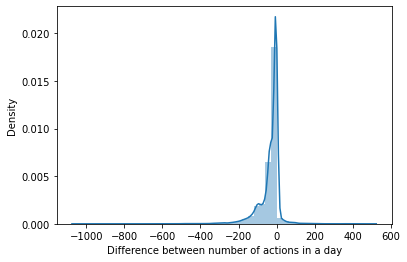

In [ ]:
sns.distplot(get_actions_difference(all_actions_2d));
plt.xlabel('Difference between number of actions in a day');

In [ ]:
def get_time_features(events, submissions):
    events_tf = events.copy()
    events_tf['hour'] = events.time.dt.floor('H')
    events_tf = events_tf.groupby('user_id').agg({
        'hour': 'nunique' # количество уникальных часов в events
    }).rename(columns={'hour': 'uniq_hour_evn'})

    submissions_tf = submissions.copy()
    submissions_tf['hour'] = submissions.time.dt.floor('H')
    submissions_tf = submissions_tf.groupby('user_id').agg({
        'hour': 'nunique' # количество уникальных часов в submissions
    }).rename(columns={'hour': 'uniq_hour_sub'})
    
    time_features_df = events_tf.merge(submissions_tf, on='user_id', how='outer').fillna(0).astype(int)
    assert time_features_df.index.nunique() == events.user_id.nunique()
    return time_features_df

In [ ]:
stats.spearmanr(get_time_features(events_2d, submissions_2d).uniq_hour_evn, train_df_base.num_days)

SpearmanrResult(correlation=0.7885797865092311, pvalue=0.0)

In [ ]:
stats.spearmanr(get_time_features(events_2d, submissions_2d).uniq_hour_evn, get_time_features(events_2d, submissions_2d).uniq_hour_sub)

SpearmanrResult(correlation=0.7507263071061162, pvalue=0.0)

## Пользователи, которым надоело

Степы на которых чаще всего заканчивают прохождение курса:

In [ ]:
def get_last_actions(actions_df):
  max_timestamps = actions_df.groupby('user_id')[['timestamp']].max().rename(columns={'timestamp': 'max_timestamp'})
  last_actions = actions_df.merge(max_timestamps, on='user_id').\
    query('timestamp == max_timestamp').drop_duplicates(['user_id']).drop(columns='max_timestamp').set_index('user_id')
  return last_actions

In [ ]:
last_actions = get_last_actions(all_actions_2d) 
last_actions.step_id.value_counts().head(10)

32815     1663
32927     1375
32191     1246
32950      736
32816      667
32979      558
31956      543
31978      526
32176      423
120745     335
Name: step_id, dtype: int64

In [ ]:
targets.loc[last_actions.query('step_id == 32815').index].value_counts()

passed_course
0                1593
1                  70
dtype: int64

In [ ]:
train_df_base.loc[last_actions.query('step_id == 32815').index].sum(axis=1).value_counts().head(10)

4     1298
7       59
5       47
6       38
8       35
10      21
9       14
11      11
12      10
32       8
dtype: int64

In [ ]:
get_users(all_actions_2d)

,user_id
0,1
1,2
2,3
3,5
4,7
...,...
19229,26790
19230,26793
19231,26794
19232,26797


In [ ]:
def get_last_action_features(step_ids, actions_df, feature_name):
  users = get_users(actions_df)
  last_actions = get_last_actions(actions_df)
  
  selected_users = last_actions[last_actions.step_id.isin(step_ids)].index
  users[feature_name] = users.user_id.isin(selected_users).astype(int).set_index('user_id')

  return users


In [ ]:
# номера степов, действия с которыми чаще всего совершаются перед уходом с курса
top_last_actions = last_actions.step_id.value_counts().head(10).index
# пользователи, завершающие взаимодействие с курсом на этих степах
users_with_last_actions_in_top_last_actions = last_actions[last_actions.step_id.isin(top_last_actions)].index
# сколько из них закончили
targets.loc[users_with_last_actions_in_top_last_actions].value_counts()

passed_course
0                7379
1                 693
dtype: int64

In [ ]:
last_submissions = get_last_actions(submissions_2d)
last_submissions.step_id.value_counts().head()

32812    3413
31978    1338
32929     441
31977     440
32175     387
Name: step_id, dtype: int64

In [ ]:
targets.loc[last_submissions.query('step_id == 32812').index].value_counts()

passed_course
0                3051
1                 362
dtype: int64

Самые сложные степы по доле верных решений:

In [ ]:
steps_submissions = submissions_2d.pivot_table(
    index='step_id',
    columns='submission_status',
    values='timestamp',
    aggfunc='count',
    fill_value=0
)
steps_submissions['correct_rate'] = steps_submissions.correct / (steps_submissions.correct + steps_submissions.wrong)

In [ ]:
hard_steps = steps_submissions.sort_values(by='correct_rate', ascending=True).head(20)
hard_steps = hard_steps.query('correct + wrong > 2000')
hard_steps

submission_status,correct,wrong,correct_rate
step_id,,,
32202,1008,2890,0.258594
32031,1739,4201,0.292761
32206,847,1914,0.306773
31978,3195,6924,0.315743
32075,1266,2342,0.350887
32174,1666,2470,0.402805


In [ ]:
hard_steps.index

Int64Index([32202, 32031, 32206, 31978, 32075, 32174], dtype='int64', name='step_id')

In [ ]:
steps_submissions.correct.sort_values(ascending=False).head(10)

step_id
32929     8038
32812     7459
32219     4418
31977     4280
31976     3907
31972     3803
31971     3467
31978     3195
120745    2775
32175     1769
Name: correct, dtype: int64

In [ ]:
steps_submissions.wrong.sort_values(ascending=False).head(10)

step_id
31978    6924
31972    4791
32031    4201
31977    3845
32812    3664
31976    3181
31971    3111
32202    2890
32174    2470
32075    2342
Name: wrong, dtype: int64

In [ ]:
def get_correct_ratio(df):
    """Создание фичи с долей правильных ответов"""
    df['correct_ratio'] = (df.correct / (df.correct + df.wrong)).fillna(-1)
    
    return df

In [ ]:
def get_step_count(df, name):
    step_count = df.groupby('user_id', as_index=False)[['step_id']].nunique().rename(columns={'step_id': name})
    
    return step_count

In [ ]:
ohe_step = pd.get_dummies(
    submissions_2d[(submissions_2d.submission_status == 'correct')
      & (submissions_2d.step_id.isin(hard_steps.index))],
      columns=['step_id']
    )
ohe_step.groupby('user_id').sum().iloc[:, -6:]

,step_id_31978,step_id_32031,step_id_32075,step_id_32174,step_id_32202,step_id_32206
user_id,,,,,,
16,1,1,1,1,1,1
22,1,1,1,1,0,0
26,1,0,0,0,0,0
34,1,0,0,0,0,0
43,1,0,0,0,0,0
...,...,...,...,...,...,...
26750,1,1,1,1,1,1
26755,1,1,1,1,0,0
26763,1,1,1,1,1,1


In [ ]:
def get_steps_ohe_features(step_ids, submissions):
    
    # прошел ли пользователь степы из step_ids
    ohe_step = pd.get_dummies(
        submissions[(submissions.submission_status == 'correct') 
                       & (submissions.step_id.isin(step_ids))], 
        columns=['step_id']
    )
    steps_features = ohe_step.groupby('user_id').sum().iloc[:, -len(step_ids):]
    
    return steps_features
    

def get_custom_features(df):
    # отобранные фичи
    df['dis_to_cor'] = df.discovered - df.correct # ???
    df['loss_step'] = df.started_attempt - df.correct # число неверных решений степов (на самом деле нет)
    df['step_pas'] = df.evn_steps - df.passed # число просмотренных, но не пройденных степов (на самом деле нет)
    df['start_pas'] = df.started_attempt - df.passed # ???
    df['all_sum'] = df[['correct', 'wrong', 'discovered', 'passed', 'started_attempt', 'viewed']].sum(axis=1)
    df['all_pass'] = df.all_sum - df.evn_steps
    
    return df

In [ ]:
train_df_base.merge(get_time_features(events_2d, submissions_2d), on='user_id')

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,uniq_hour_evn,uniq_hour_sub
user_id,,,,,,,,,
1,1,0,0,1,0,0,1,1,0
2,9,9,2,9,2,0,1,1,1
3,15,15,4,20,4,4,1,2,2
5,1,1,0,1,0,0,1,1,0
7,1,1,0,1,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...
26790,2,2,0,2,0,0,1,1,0
26793,1,0,1,1,0,0,1,1,0
26794,50,50,24,90,24,7,2,13,10


In [ ]:
def create_work_df(events, submissions, last_action_step_ids=None, last_sub_step_ids=None, ohe_step_ids=None, target=None):
    '''
    Сборка датасета для работы с моделью
    '''
    actions = create_interaction(events, submissions)
    df = get_base_features(actions)
    
    df = df.merge(get_actions_difference(actions), on='user_id')

    time_features = get_time_features(events, submissions)
    df = df.merge(time_features, on='user_id')

    if last_action_step_ids is not None:
      df = df.merge(get_last_action_features(last_action_step_ids, actions, 'last_action_f'))

    if last_sub_step_ids is not None:
      df = df.merge(get_last_action_features(last_sub_step_ids, submissions, 'last_sub_f'))
    
    df = df.merge(get_step_count(submissions, 'sub_steps'), on='user_id', how='outer').fillna(0)
    df = df.merge(get_step_count(events, 'evn_steps'), on='user_id')

    if ohe_step_ids is not None:
      df = df.merge(get_steps_ohe_features(ohe_step_ids, submissions), on='user_id', how='outer').fillna(0)

    df = get_correct_ratio(df)
    df = get_custom_features(df)
    
    if target is not None:
        # добавление целевой переменной
        df = df.merge(target, on='user_id', how='outer').fillna(0)
    
    df = df.drop(columns='user_id')

    return df.astype('int')

In [ ]:
create_work_df(events_2d, submissions_2d)

,discovered,passed,started_attempt,viewed,correct,wrong,num_days,act_diff_day,uniq_hour_evn,uniq_hour_sub,sub_steps,evn_steps,correct_ratio,dis_to_cor,loss_step,step_pas,start_pas,all_sum,all_pass
0,1,0,0,1,0,0,1,-2,1,0,0,1,-1,1,0,1,0,2,1
1,9,9,2,9,2,0,1,-31,1,1,2,9,1,7,0,0,-7,31,22
2,15,15,4,20,4,4,1,-62,2,2,4,15,0,11,0,0,-11,62,47
3,1,1,0,1,0,0,1,-3,1,0,0,1,-1,1,0,0,-1,3,2
4,1,1,0,1,0,0,1,-3,1,0,0,1,-1,1,0,0,-1,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19229,2,2,0,2,0,0,1,-6,1,0,0,2,-1,2,0,0,-2,6,4
19230,1,0,1,1,0,0,1,-3,1,0,0,1,-1,1,1,1,1,3,2
19231,50,50,24,90,24,7,2,-33,13,10,22,50,0,26,0,0,-26,245,195
19232,10,10,2,10,2,0,1,-34,1,1,2,10,1,8,0,0,-8,34,24


ROC-AUC на тренировочной выборке:	 0.9157775333339934
ROC-AUC на тестовой выборке:	 0.8269041411561378

Mean CV score: 0.8302930072148659
Std of CV scores: 0.010824981013085884


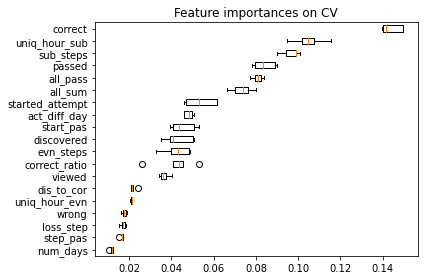

In [ ]:
test_model(rf, create_work_df(events_2d, submissions_2d), targets)